# Ames, Iowa Housing Price Predictions

### Overview
I completed this project as part of a Kaggle competition (see here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques). I visualized the various aspects of the dataset prior to cleaning null values, feature engineering, and creating an ensemble model. 

I generated ensemble predictions consisting of the the Extreme Gradient Boosting (XGBoost) decision-tree algorithm and Ridge regression. Prior to creating the XGBoost model, I performed hyper-parameter grid search optimization to prevent over-fitting the training data during cross-validation. 

The metric used for scoring by Kaggle is the root mean squared logarithmic error (RMSLE). This metric is similar to the more common root mean squared error, but does not penalize as heavily for extreme differences between actual and predicted values due to the logarithm. My final RMSLE was 0.11824. When comparing my final result to other Kaggle competitors, my model places within the top 15% (~385 out of 2400) as of November 14th, 2017. 

Additional work with feature engineering, adding additional models to the ensemble, and improving the replacement of null values / outliers could potentially further improve this model.

### Key Results
My RMSLE of 0.11824 would place ~385 out of 2400 entries (top 30%) as of November 14th, 2017.

### Methods used
- seaborn for feature visualization
- pandas dummy variables for transforming nominal features
- XGBoost modeling and predictions
- Ridge Regression

# Reading in the Provided Dataset
The dataset contains roughly 3000 entries with various features that describe the house. The training set contain 1460 labeled samples with the final sale price, while the test set contains 1459 samples without the target sale price. The dataset was compiled by Dean De Cock: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import pearsonr


train = pd.read_csv('train.csv')
train = train.drop('Id', axis=1)
test = pd.read_csv('test.csv')
test = test.drop('Id', axis=1)

print('train rows and features:', train.shape)
print('test rows and features:', test.shape)
train.head()

train rows and features: (1460, 80)
test rows and features: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Plotting the target variable—Sale Price
The sale price shows a slight skew towards higher prices, with a few potential outliers. Log transforming the data improves normality.

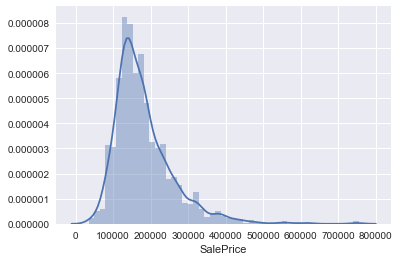

In [2]:
sns.distplot(train.SalePrice);

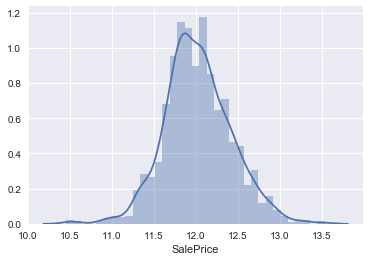

In [3]:
sns.distplot(np.log(train.SalePrice))

# Visualizing Feature Correlations with Seaborn Heatmap
While there are some features with high multicollinearity, overall the features appear to be relatively independent. Also note that this plot only shows the numerical features from the dataset. The dataset contains 80 features, but only 36 are numerical. The remaining 44 nominal features will be dealth with later on. 

### Top 15 Features with Highest Correlation with Sale Price
Below the top 15 feature correlations with the target are shown. Overall quality, Living Area, Garage Area, and Basement size all seems to correlate strongly with the final sale price. The next few plots will show distributions with these features and the target Sale Price.

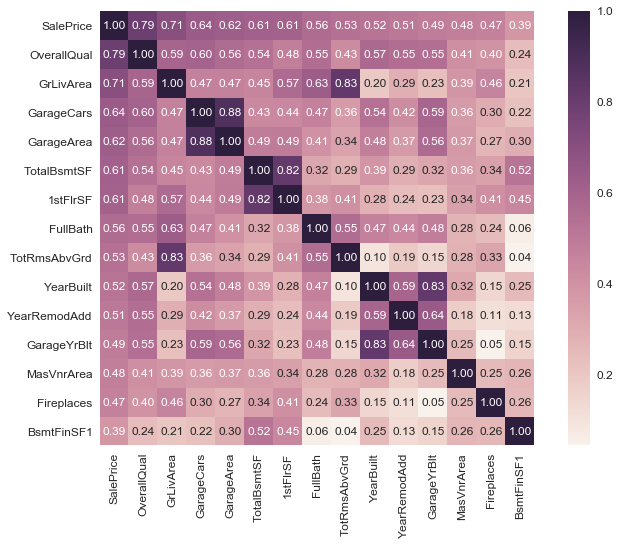

In [4]:
plt.figure(figsize=(12,8))
k = 15
corrmat = abs(train.corr())
cols_large = corrmat.nlargest(k, 'SalePrice').index
hm_large = corrmat.nlargest(k,'SalePrice')[cols_large]
sns.set(font_scale=1.2)
sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12})

# Visualizing Important Features and Removing Outliers

### Overal Quality Score

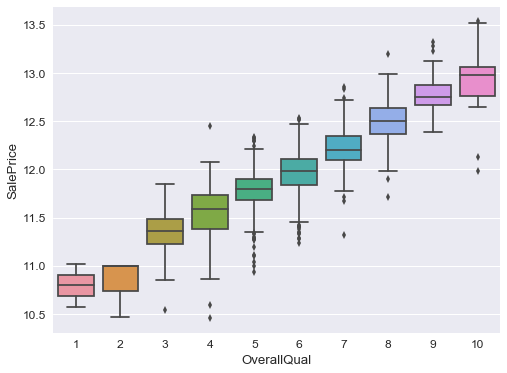

In [5]:
var = 'OverallQual'
data_plot = pd.concat([np.log(train['SalePrice']), train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data_plot)

### Above Ground Living Area

There are a few outliers in the first plot, which the dataset author notes are due to short sales. I filtered the 5 houses with living area above 4000 to prevent them from skewing the final results.

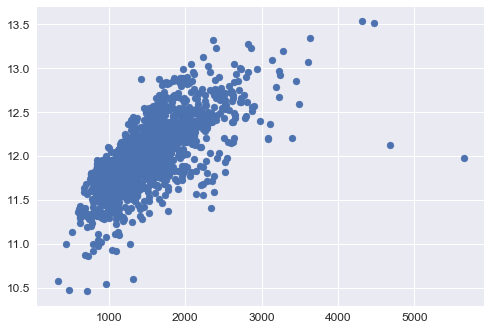

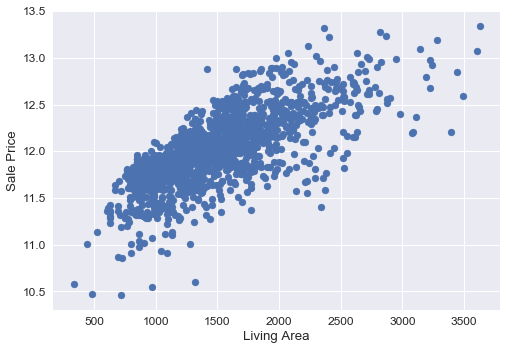

(1456, 80)

In [6]:
plt.scatter(train['GrLivArea'], np.log(train.SalePrice))
plt.show()
plt.xlabel('Living Area'), plt.ylabel('Sale Price')
train = train[train['GrLivArea'] < 4000].reset_index(drop=True)
plt.scatter(train['GrLivArea'], np.log(train.SalePrice))
plt.show()
train.shape

### Garage Area
The outliers at the higher end are not as drastic as shown previously, but I chose to filter at 1200 sq ft. Further, the number of houses without a garage shows an interesting trend.

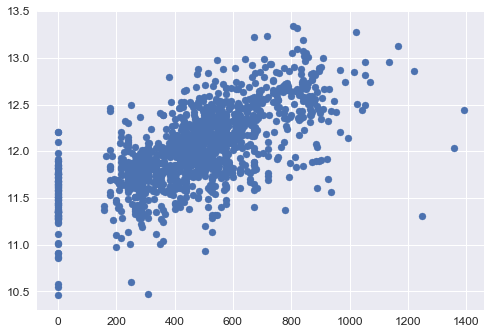

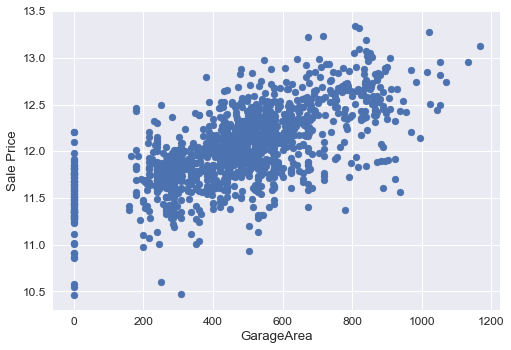

(1452, 80)

In [7]:
plt.scatter(train['GarageArea'], np.log(train.SalePrice))
plt.show()
plt.xlabel('GarageArea'), plt.ylabel('Sale Price')
train = train[train['GarageArea'] < 1200].reset_index(drop=True)
plt.scatter(train['GarageArea'], np.log(train.SalePrice))
plt.show()
train.shape

### Total Basement Square Feet

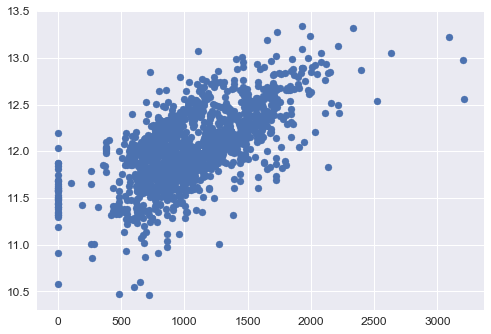

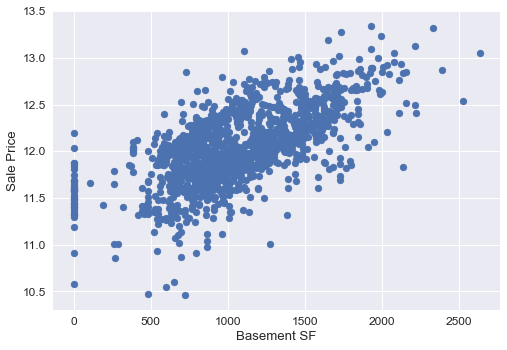

(1449, 80)

In [8]:
plt.scatter(train['TotalBsmtSF'], np.log(train.SalePrice))
plt.show()
plt.xlabel('Basement SF'), plt.ylabel('Sale Price')
train = train[train['TotalBsmtSF'] < 3000].reset_index(drop=True)
plt.scatter(train['TotalBsmtSF'], np.log(train.SalePrice))
plt.show()
train.shape

### Total Lot Area
Here I filtered at 40,000 sq. ft, which removed a few of the more drastic outliers.

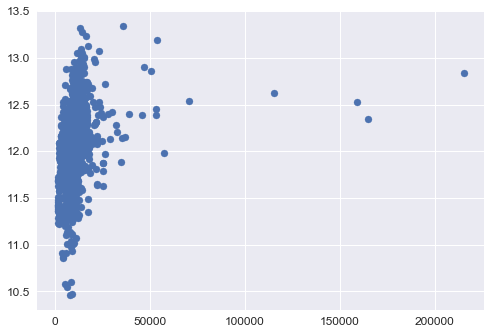

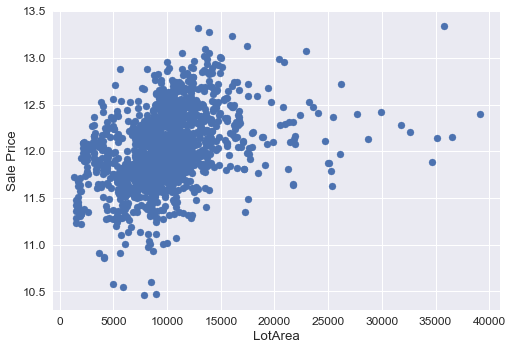

(1437, 80)

In [9]:
plt.scatter(train['LotArea'], np.log(train.SalePrice))
plt.show()

train = train[train['LotArea'] < 40000].reset_index(drop=True)
plt.scatter(train['LotArea'], np.log(train.SalePrice))
plt.xlabel('LotArea'), plt.ylabel('Sale Price')
plt.show()
train.shape

# Engineering New Features

In [10]:
train_length = train.shape[0]
combined = pd.concat([train, test], axis=0).reset_index(drop=True)

### Age Since Remodel and Built
I ended up combining the years since the house was built and years since the house was remodeled into a single metric that represents both of these together. It shows a higher correlation in the 2nd plot below.

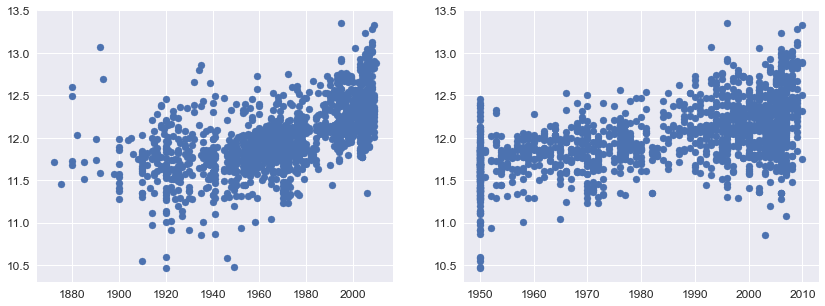

In [11]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(train['YearBuilt'], np.log(train.SalePrice))
ax2.scatter(train['YearRemodAdd'], np.log(train.SalePrice))
plt.show()

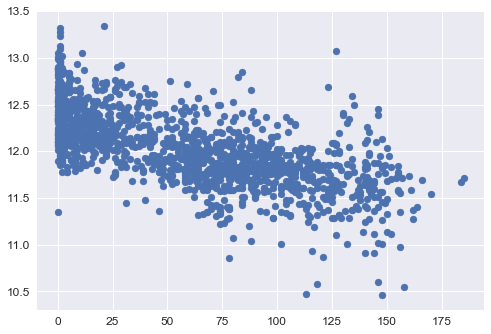

In [12]:
combined['age_sale_remodel'] = (combined['YrSold'] - combined['YearRemodAdd']) + (combined['YrSold'] - combined['YearBuilt'])
plt.scatter(combined['age_sale_remodel'], np.log(combined.SalePrice))
plt.show()

### Total square footage, including garage and basement
I also created a total square footage that includes the garage, basement, and above ground living area.

(<matplotlib.text.Text at 0x115b42668>, <matplotlib.text.Text at 0x11612c780>)

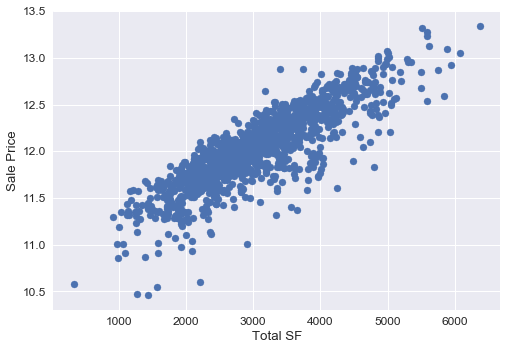

In [13]:
combined["totalSF"] = combined["TotalBsmtSF"] + combined["1stFlrSF"] + combined["2ndFlrSF"] + combined['GarageArea']
plt.scatter(combined['totalSF'], np.log(combined.SalePrice))
plt.xlabel('Total SF'), plt.ylabel('Sale Price')

The new features correlate well with the target and show up in the top 15 features.

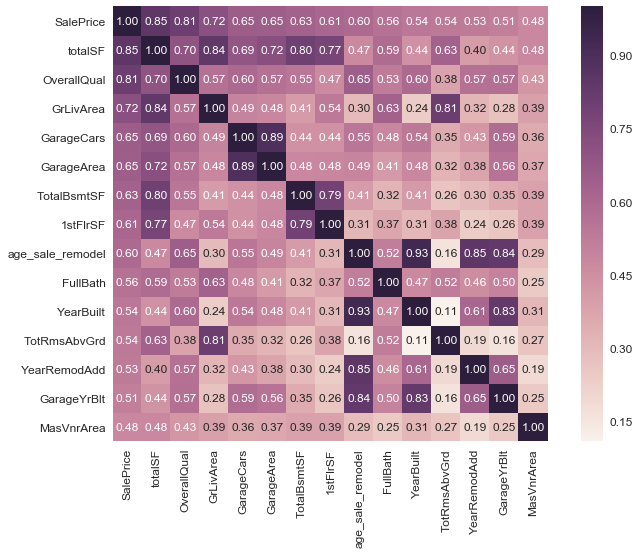

In [14]:
plt.figure(figsize=(12,8))
k = 15
corrmat = abs(combined.corr())
cols_large = corrmat.nlargest(k, 'SalePrice').index
hm_large = corrmat.nlargest(k,'SalePrice')[cols_large]
sns.set(font_scale=1.2)
sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12})

# Missing Values and Converting Nominal to Ordinal
Below, I show the missing values for the object features. There are a high number of missing features, which is typically due to the house not having that particular object (e.g. a fireplace).

In [15]:
combined_objects = combined.select_dtypes(include=['object'])
print('number of object features:', combined_objects.shape[1])

number of object features: 43


In [16]:
combined_objects.isnull().sum()[combined_objects.isnull().sum()>0]

Alley           2698
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      79
BsmtQual          81
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2326
FireplaceQu     1419
Functional         2
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
KitchenQual        1
MSZoning           4
MasVnrType        24
MiscFeature     2794
PoolQC          2888
SaleType           1
Utilities          2
dtype: int64

I decided to remove a few of the nominal features that provided little information.

In [17]:
del combined['Alley']
del combined['MiscFeature']
del combined['PoolQC']
del combined['MSSubClass']

Many nominal features had a breakdown from excellent to poor, as shown below. For these, I changed the variable to ordinal, with a score of 0–5.

In [18]:
combined.FireplaceQu.value_counts()

Gd    731
TA    585
Fa     73
Po     46
Ex     42
Name: FireplaceQu, dtype: int64

In [19]:
ordinal_cols = ['FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
               'HeatingQC', 'ExterQual', 'ExterCond', 'KitchenQual']
for col in ordinal_cols:
    combined[col] = combined[col].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}).fillna(0)

Other nominal features had ordering to them, but not in the same poor to excellent scale. For these, I manually looked at the descriptions of the features and replaced them with ordinal values, where possible.

In [20]:
combined.Fence.value_counts()

MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

In [21]:
combined['BsmtFinType1'] = combined['BsmtFinType1'].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf':1}).fillna(0)
combined['BsmtFinType2'] = combined['BsmtFinType2'].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf':1}).fillna(0)
combined['BsmtExposure'] = combined['BsmtExposure'].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}).fillna(0)

combined['Fence'] = combined['Fence'].replace({'GdPrv': 2, 'GdWo': 2, 'MnPrv': 1, 'MnWw': 1}).fillna(0)
combined['GarageType'] = combined['GarageType'].replace({'2Types': 5, 'Attchd': 4, 'BuiltIn': 4, 'Basment': 3, 'CarPort':2, 'Detchd':2}).fillna(0)
combined['GarageFinish'] = combined['GarageFinish'].replace({'Fin': 3, 'RFn': 2, 'Unf': 1}).fillna(0)

combined['HouseStyle'] = combined['HouseStyle'].replace({'1Story':1, '1.5Fin':1.5, '1.5Unf':1.25, '2Story': 2, '2.5Fin':2.5, '2.5Unf':2.25, 'SFoyer': 1.25, 'SLvl': 1.25})
combined['BldgType'] = combined['BldgType'].replace({'1Fam': 3, '2FmCon': 2, 'Duplx': 2, 'TwnhsE': 1.5, 'TwnhsI': 1})

The remaining null values are relatively minimal compared to the start.

In [22]:
combined_objects = combined.select_dtypes(include=['object'])
print('number of object features:', combined_objects.shape[1])
combined_objects.isnull().sum()[combined_objects.isnull().sum()>0]

number of object features: 24


Electrical      1
Exterior1st     1
Exterior2nd     1
Functional      2
MSZoning        4
MasVnrType     24
SaleType        1
Utilities       2
dtype: int64

### Get dummies and creating target and features
The remaining nominal features will be transformed using get_dummies. It ends up producing 164 dummy features, which is much reduced from 280 that would have occurred if I did not transfrom some to ordinal above.

In [23]:
dummies = pd.get_dummies(combined_objects)
print('number of dummies features:', dummies.shape[1])

number of dummies features: 164


(2896, 54)


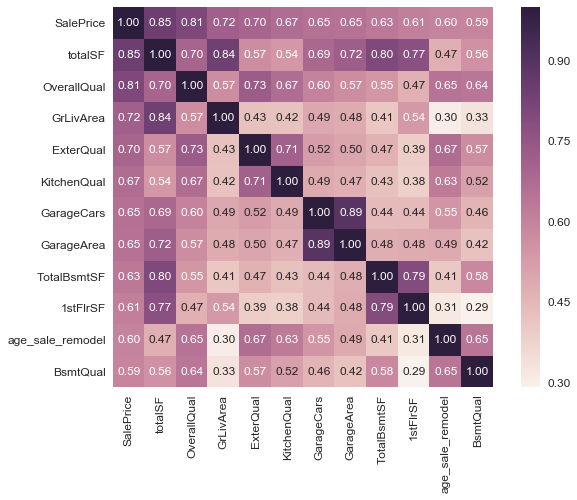

In [24]:
combined_numeric = combined.drop(combined_objects.columns, axis=1)
print(combined_numeric.shape)

plt.figure(figsize=(10,7))
k = 12
corrmat = abs(combined_numeric.corr())
cols_large = corrmat.nlargest(k, 'SalePrice').index
hm_large = corrmat.nlargest(k,'SalePrice')[cols_large]
sns.set(font_scale=1.2)
sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12})

In [25]:
combined_new = pd.concat([combined_numeric, dummies], axis=1)
print('samples and features in data set:', combined_new.shape)

samples and features in data set: (2896, 218)


### Filling in remaining null values

The majority of the null values remaining are numerical variables, where the house does not have the feature (e.g. a garage). For these, I replaced with the minimum value in the series.

In [26]:
combined_new.isnull().sum()[combined_new.isnull().sum()>0]

BsmtFinSF1         1
BsmtFinSF2         1
BsmtFullBath       2
BsmtHalfBath       2
BsmtUnfSF          1
GarageArea         1
GarageCars         1
GarageYrBlt      159
LotFrontage      478
MasVnrArea        23
SalePrice       1459
TotalBsmtSF        1
totalSF            2
dtype: int64

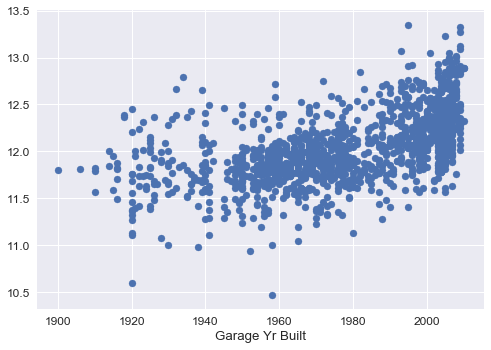

In [27]:
plt.scatter(combined_new.GarageYrBlt, np.log(combined_new.SalePrice))
plt.xlabel('Garage Yr Built')

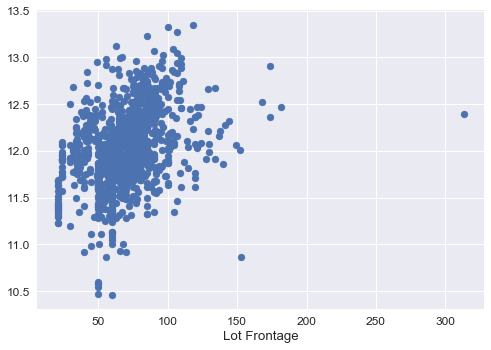

In [28]:
plt.scatter(combined_new.LotFrontage, np.log(combined_new.SalePrice))
plt.xlabel('Lot Frontage')

In [29]:
combined_new['GarageYrBlt'] = combined_new['GarageYrBlt'].fillna(combined_new.GarageYrBlt.min())
combined_new['LotFrontage'] = combined_new['LotFrontage'].fillna(combined_new.GarageYrBlt.min())
combined_new['GarageYrBlt'] = combined_new['GarageYrBlt'].replace({2207:2006})

In [30]:
combined_new.isnull().sum()[combined_new.isnull().sum()>0]

BsmtFinSF1         1
BsmtFinSF2         1
BsmtFullBath       2
BsmtHalfBath       2
BsmtUnfSF          1
GarageArea         1
GarageCars         1
MasVnrArea        23
SalePrice       1459
TotalBsmtSF        1
totalSF            2
dtype: int64

In [31]:
combined_new = combined_new.fillna(combined_new.mean())
combined_new.isnull().sum()[combined_new.isnull().sum()>0]

Series([], dtype: int64)

# Creating train and prediction datasets, as well as filtering by correlation

In [32]:
X = combined_new.iloc[:train_length, :].drop('SalePrice', axis=1)
y = combined_new.SalePrice[:train_length]
print('samples and features in train set:', X.shape)

X_predict = combined_new.iloc[train_length:, :].drop('SalePrice', axis=1)
print('samples and features in predict set:', X_predict.shape)

samples and features in train set: (1437, 217)
samples and features in predict set: (1459, 217)


In [33]:
def select_features(X, y, corr_value):

    ## filters columns based on their correlation with the target
    for col in X.columns:
        corr = pearsonr(X[col], y)
        if abs(corr[0]) < corr_value:
            del X[col]
            
    return X

The number of samples and features in the training and prediction datasets are shown below after correlation filtering.

In [34]:
X = select_features(X, y, 0.05)
X_predict = X_predict[X.columns]

print('samples and features in train set:', X.shape)
print('samples and features in predict set:', X_predict.shape)

samples and features in train set: (1437, 134)
samples and features in predict set: (1459, 134)


/Users/Mark/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


# Grid Search Parameter Tuning

### Initial factorial scan

I performed a factorial scan of relevant parameters for XGBoost. The initial parameters and ranges are shown below.

In [35]:
import xgboost as xgb

log_train = xgb.DMatrix(X, label=np.log(y))

/Users/Mark/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
params_initial = {
    # Parameters to initially tune (set to defaults):
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    
    # Other parameters:
    'objective':'reg:linear',
    'eval_metric': 'mae',
    'eta': 0.3,
}

num_boost_round = 1000

In [37]:
params = params_initial

gridsearch_params = [
    (max_depth, min_child_weight, subsample, colsample_bytree, reg_lambda)
    for max_depth in range(4, 7, 2)
    for min_child_weight in range(1,7,5)
    for subsample in np.arange(.5, 1.1, 0.5)
    for colsample_bytree in np.arange(0.5, 1.1, 0.5)
    for reg_lambda in range(1, 4, 2)
]
len(gridsearch_params)

32

The code below performs a 5-fold cross-validation for each combination of factors being studied. The results will be plotted in the following code cells.

In [38]:
# prepare dataframe for storing results
count = 0
results = pd.DataFrame()

for max_depth, min_child_weight, subsample, colsample_bytree, reg_lambda in gridsearch_params:

    # Update parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    params['reg_lambda'] = reg_lambda

    # Run CV
    cv_results = xgb.cv(
        params,
        log_train,
        num_boost_round=num_boost_round,
        seed=1,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )

    mean_rmse = cv_results['test-rmse-mean'].min()

    keys = list(params.keys())
    keys.append('mean_rmse')
    vals = [val for val in params.values()]
    vals.append(mean_rmse)
    
    result_series = pd.Series(vals, index=keys, name=count)
    results = results.append(result_series)
    count += 1

Below is a sample of the mean rmse for each combination of studied factors.

In [39]:
numeric_results = results.drop(['eval_metric', 'objective', 'eta', 'reg_alpha'], axis=1).astype('float')
numeric_results.head()

,colsample_bytree,max_depth,mean_rmse,min_child_weight,reg_lambda,subsample
0,0.5,4.0,0.130475,1.0,1.0,0.5
1,0.5,4.0,0.133289,1.0,3.0,0.5
2,1.0,4.0,0.130622,1.0,1.0,0.5
3,1.0,4.0,0.137736,1.0,3.0,0.5
4,0.5,4.0,0.131817,1.0,1.0,1.0


In [40]:
numeric_results.iloc[numeric_results.mean_rmse.argmin(),:]

colsample_bytree    0.500000
max_depth           4.000000
mean_rmse           0.123464
min_child_weight    6.000000
reg_lambda          3.000000
subsample           1.000000
Name: 13, dtype: float64

In [41]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def regression_fit_plot(df, target, alpha, show_plot):
    
    # specifying target and features
    X = df.drop(target, axis=1)
    y = df[target]

    # creating binary interaction terms
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(X)
    poly_names = poly.get_feature_names(X.columns)
    poly_X = pd.DataFrame(poly_features, columns=poly_names)
    
    from sklearn.linear_model import Ridge

    X_norm = (poly_X - poly_X.min()) / (poly_X.max() - poly_X.min())
    model = Ridge(alpha=alpha).fit(X_norm, y)
    m = model.coef_
 
    # making the plot of coefficient
    if show_plot == True:
        #del m['const']

        fig = plt.figure(figsize=(14,7))
        ax = fig.add_subplot(1,1,1)
        ax.bar(range(len(m)), m, 0.5,  color='blue',)
        ax.set_xticks(range(len(m)))
        ax.set_xticklabels(poly_X.columns, rotation = 90)
        plt.ylabel('Correlation Coefficients')
        plt.show()

/Users/Mark/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


As shown below, max_depth, subsample, and min_child_weight are all predominant factors. Further, a number of binary interactions are also important.

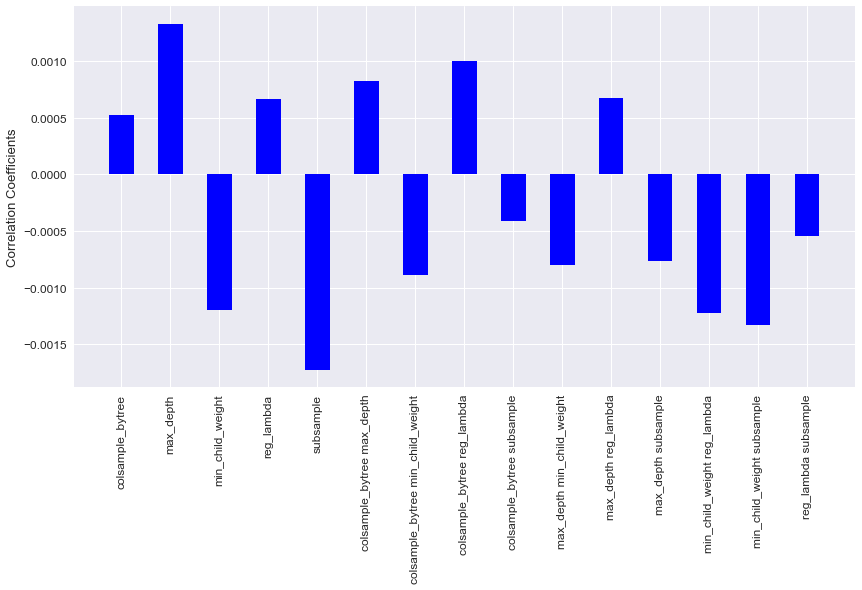

In [42]:
target = 'mean_rmse'
alpha = 5
show_plot = True

regression_fit_plot(numeric_results, 'mean_rmse', alpha, show_plot)

In [43]:
print(pd.pivot_table(numeric_results, values='mean_rmse', index=['max_depth'], aggfunc='mean'))
print(pd.pivot_table(numeric_results, values='mean_rmse', index=['subsample'], aggfunc='mean'))
print(pd.pivot_table(numeric_results, values='mean_rmse', index=['reg_lambda'], aggfunc='mean'))
print(pd.pivot_table(numeric_results, values='mean_rmse', index=['min_child_weight'], aggfunc='mean'))
print(pd.pivot_table(numeric_results, values='mean_rmse', index=['colsample_bytree'], aggfunc='mean'))

           mean_rmse
max_depth           
4.0         0.129851
6.0         0.132051
           mean_rmse
subsample           
0.5         0.133013
1.0         0.128889
            mean_rmse
reg_lambda           
1.0          0.130285
3.0          0.131617
                  mean_rmse
min_child_weight           
1.0                0.133357
6.0                0.128545
                  mean_rmse
colsample_bytree           
0.5                0.130313
1.0                0.131589


### Finetuning critical parameters

The most critical parameters from above will be further optimized based on the initial results.

In [44]:
params = params_initial

num_boost_round = 1000

gridsearch_params = [
    (max_depth, subsample, min_child_weight, colsample_bytree)
    for max_depth in range(3, 6, 1)
    for subsample in np.arange(.5, 1.1, 0.25)
    for min_child_weight in range(6, 13, 3)
    for colsample_bytree in np.arange(0.25, 0.8, .25)
]
len(gridsearch_params)

81

In [45]:
# Initialize results dataframe and trial counts
count = 0
results = pd.DataFrame()

for max_depth, subsample, min_child_weight, colsample_bytree in gridsearch_params:

    # Update parameters
    params['max_depth'] = max_depth
    params['subsample'] = subsample
    params['min_child_weight'] = min_child_weight
    params['colsample_bytree'] = colsample_bytree
    
    # Run CV
    cv_results = xgb.cv(
        params,
        log_train,
        num_boost_round=num_boost_round,
        seed=1,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    
    # Pull out best result for run
    mean_rmse = cv_results['test-rmse-mean'].min()
    
    # obtain column headings for dataframe
    keys = list(params.keys())
    keys.append('mean_rmse')
    
    # obtain parameter values used for run
    vals = [val for val in params.values()]
    vals.append(mean_rmse)
    
    # add results to dataframe
    result_series = pd.Series(vals, index=keys, name=count)
    results = results.append(result_series)
    count += 1

In [46]:
numeric_results = results.drop(['eval_metric', 'objective', 'eta', 'reg_lambda', 'reg_alpha'], axis=1).astype('float')
numeric_results.head()

,colsample_bytree,max_depth,mean_rmse,min_child_weight,subsample
0,0.25,3.0,0.129931,6.0,0.5
1,0.50,3.0,0.132331,6.0,0.5
2,0.75,3.0,0.130592,6.0,0.5
3,0.25,3.0,0.129465,9.0,0.5
4,0.50,3.0,0.132182,9.0,0.5


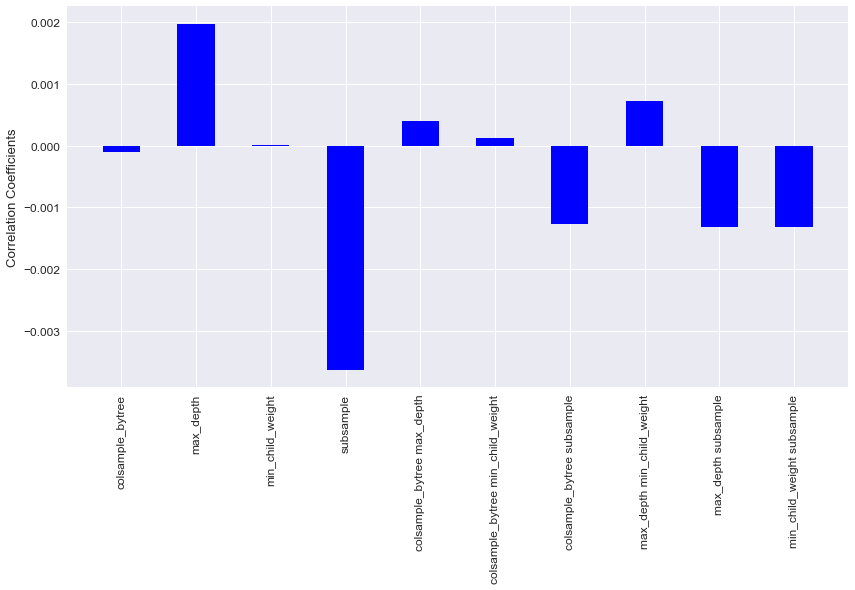

In [47]:
target = 'mean_rmse'
alpha = 5
show_plot = True

regression_fit_plot(numeric_results, 'mean_rmse', alpha, show_plot)

The best results from the experiment are shown below. These results will serve as a baseline for training the XGBoost model and making predictions on the prediction set.

In [48]:
numeric_results.sort_values('mean_rmse', ascending=True).head(10)

,colsample_bytree,max_depth,mean_rmse,min_child_weight,subsample
23,0.75,3.0,0.121197,9.0,1.00
18,0.25,3.0,0.121282,6.0,1.00
76,0.50,5.0,0.122787,9.0,1.00
51,0.25,4.0,0.122849,12.0,1.00
24,0.25,3.0,0.123174,12.0,1.00
46,0.50,4.0,0.123464,6.0,1.00
10,0.50,3.0,0.123723,6.0,0.75
73,0.50,5.0,0.123810,6.0,1.00
22,0.50,3.0,0.123950,9.0,1.00
19,0.50,3.0,0.123970,6.0,1.00


In [49]:
params = params_initial

params['colsample_bytree'] = 0.4
params['max_depth'] = 3
params['min_child_weight'] = 6
params['subsample'] = .4
params['reg_lambda'] = 10

# Machine Learning Modeling and Predictions

In [50]:
## function for calculating the RMSLE for a predicted and actual dataset

def rmsle(predicted, actual):
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    return (((p - a)**2).sum() / len(predicted))**0.5

## XGBoost Model

This function takes in the optimized parameters, trains the model using 10-fold validation and then uses the model to make the predictions.

In [51]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

def train_and_test(X, y, X_predict, params, folds):
    
    # specifying model hyperparameters
    est = params['estimators']
    esr = params['early_stopping_rounds']
    lr = params['eta']
    csbt = params['colsample_bytree']
    md = params['max_depth']
    mcw = params['min_child_weight']
    ra = params['reg_alpha']
    rl = params['reg_lambda']
    ss = params['subsample']
    
    # creating empty lists to store error metrics for each k-fold iteration
    rmsles_train = []
    rmsles_test = []

    df_predictions = pd.DataFrame()
    count = 1

    # initializing k-fold cross validation        
    folds = KFold(n_splits=folds, shuffle=True, random_state=2)
        
    for train_index, test_index in folds.split(range(0, X.shape[0])):
        
        # using the train and test indices from k-fold split to subset train and test data
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        model = XGBRegressor(n_estimators=est, learning_rate=lr, colsample_bytree=csbt, max_depth=md,
                                 min_child_weight=mcw, reg_alpha=ra, reg_lambda=rl, subsample=ss)
        model.fit(X_train, y_train, early_stopping_rounds=esr, eval_metric="rmse", 
                      eval_set=[(X_test, y_test)], verbose=False)
        
        # calculating RMSE and R^2 error metrics for the training data
        train_pred = model.predict(X_train)
        rmsle_train = rmsle(train_pred, y_train)
        rmsles_train.append(rmsle_train)
      
        # predicting the test data and calculating RMSE and R^2 error metric for the test set
        test_pred = model.predict(X_test)
        rmsle_test = rmsle(test_pred, y_test)
        rmsles_test.append(rmsle_test)

        # making predictions for the upcoming 2017 season
        df_predictions[count] = model.predict(X_predict)
        count +=1
    
    df_predictions['mean_pred_price'] = df_predictions.mean(axis=1)

    #returning the average error metrics and dataframe containing next season's predictions
    return np.mean(rmsles_train), np.mean(rmsles_test), df_predictions['mean_pred_price']

Re-creating the datasets for modeling.

In [52]:
X = combined_new.iloc[:train_length, :].drop('SalePrice', axis=1)
y = combined_new.SalePrice[:train_length]
X_predict = combined_new.iloc[train_length:, :].drop('SalePrice', axis=1)

X = select_features(X, y, 0.05).astype('float')
X_predict = X_predict[X.columns].astype('float')

print('samples and features in train set:', X.shape)
print('samples and features in predict set:', X_predict.shape)

samples and features in train set: (1437, 134)
samples and features in predict set: (1459, 134)


/Users/Mark/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [53]:
params['estimators'] = 1000
params['early_stopping_rounds'] = 25
params['eta'] = 0.05

Below, the train and testing error are shown for the optimized case. While these is some variance in the model, overall the results are pretty good. If the test error carried over to the prediction set, it would rank in the top 5% of Kaggle entries (though it performs not quite as well on the predictions due to the variance.)

In [54]:
k_folds = 10

err_train, err_test, predictions = train_and_test(X, y, X_predict, params, k_folds)
print('train error:', err_train)
print('test error: ', err_test)

train error: 0.092178714947
test error:  0.113441063806


## Ridge model
To help minimize the variance of the XGBoost model, I will combine it with a regularized Ridge regression model. The function for performing the ridge regression is shown below. I ended up settling on an alpha=8.

In [55]:
from sklearn.linear_model import Ridge

folds = KFold(n_splits=10, shuffle=True, random_state=2)
        
results = pd.DataFrame()
count = 1

rmsles_train = []
rmsles_test = []

for train_index, test_index in folds.split(range(0, X.shape[0])):
        
    # using the train and test indices from k-fold split to subset train and test data
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = np.log(y)[train_index], np.log(y)[test_index]

    model = Ridge(alpha=8).fit(X_train, y_train)    
    
    # calculating RMSE and R^2 error metrics for the training data
    train_pred = model.predict(X_train)
    train_pred, y_train = np.exp(train_pred), np.exp(y_train)
    rmsle_train = rmsle(train_pred, y_train)
    rmsles_train.append(rmsle_train)
      
    # predicting the test data and calculating RMSE and R^2 error metric for the test set
    test_pred = model.predict(X_test)
    test_pred, y_test = np.exp(test_pred), np.exp(y_test)
    rmsle_test = rmsle(test_pred, y_test)
    rmsles_test.append(rmsle_test)
    
print('train error:', np.mean(rmsles_train))
print('test error: ', np.mean(rmsles_test))

train error: 0.0997341397807
test error:  0.109980329545


The Ridge model showed slightly better training and testing error compared to the XGBoost model, but overall gave comparable results.

In [56]:
ridge_predict = pd.Series(np.exp(model.predict(X_predict)))

In [57]:
ridge_predict.to_csv('predictions.csv')

# Creating and exporting ensemble predictions
Below I average the prediction results from the XGBoost and Ridge model, and export the results for entry into the Kaggle competition. This result ended up placing in ~15th percentile out of 2400 entries.

In [58]:
ensemble = pd.concat([ridge_predict, predictions], axis=1).mean(axis=1)

In [59]:
ensemble.to_csv('predictions.csv')